In [1]:
!pip install geopandas
!pip install pygeos
!pip install rtree
!pip install mapclassify
!pip install osmnx
!pip install overpass

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

In [3]:
plt.rcParams['font.size'] = 14

### Задача:

Прогноз продаж одной из популярных моделей [фичерфонов](https://ru.wikipedia.org/wiki/%D0%A4%D0%B8%D1%87%D0%B5%D1%80%D1%84%D0%BE%D0%BD) (на картинке ниже пример похожего устройства) в салонах МегаФона
![](https://39.img.avito.st/640x480/8468720439.jpg)

### Исходные данные:

Датасет содержит следующие поля:

1. `point_id` - Индентификатор салона
2. `lon` - Долгота точки
3. `lat` - Широта точки
4. `target` - Значение таргета, усредненное за несколько месяцев и отнормированное

### Требования к решению и советы:

Ниже приведен список из нескольких важных пунктов, необходимых для решения задания. Выполнение каждого из пунктов влияет на итоговую оценку. Вы можете выполнить каждый из пунктов разными способами, самым лучшим будет считаться вариант, когда всё получение и обработка данных будут реализованы на Питоне (пример: вы можете скачать данные из OSM через интерфейс на сайте overpass-turbo или с помощью библиотек `overpass`/`requests`. Оба варианта будут зачтены, но больше баллов можно заработать во втором случае)



1. Салоны расположены в нескольких разных городах, вам необходимо **определить город для каждого салона** (это понадобится во многих частях задания). К этому есть разные подходы. Вы можете провести [обратное геокодирование](https://en.wikipedia.org/wiki/Reverse_geocoding) с помощью геокодера [Nominatim](https://nominatim.org/), доступного через библиотеку `geopy` примерно вот так:
```python
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="specify_your_app_name_here")
location = geolocator.reverse("52.509669, 13.376294")
print(location.address)
```
В таком случае, вам придется обрабатывать полученную строку адреса, чтобы извлечь название города. Также вы можете скачать из OSM или найти в любом другом источнике границы административно территориальных границ России и пересечь с ними датасет с помощью `geopandas.sjoin` (этот вариант более надежный, но нужно будет разобраться с тем, как устроены границы АТД в OSM, обратите внимание на [этот тег](https://wiki.openstreetmap.org/wiki/Key:admin_level))


2. **Используйте данные OSM**: подумайте, какие объекты могут влиять на продажи фичерфонов. Гипотеза: такие телефоны покупают люди, приезжающие в город или страну ненадолго, чтобы вставить туда отдельную симкарту для роуминга. Можно попробовать использовать местоположения железнодорожных вокзалов (изучите [этот тег](https://wiki.openstreetmap.org/wiki/Tag:railway%3Dstation)). Необходимо использовать хотя бы 5 разных типов объектов из OSM. Скорее всего, вам придется качать данные OSM отдельно для разных городов (см. пример для Нью-Йорка из лекции)


3. **Используйте разные способы генерации признаков**: описать положение салона МегаФона относительно станций метро можно разными способами - найти ***расстояние до ближайшей станции***, или же посчитать, сколько станций попадает в ***500 метровую буферную зону*** вокруг салона. Такие признаки будут нести разную информацию. Так же попробуйте поэкспериментировать с размерами буферных зон (представьте, что значат в реальности радиусы 100, 500, 1000 метров). Попробуйте посчитать расстояние до центра города, до других объектов.

4. **Сделайте визуализации**: постройте 2-3 карты для какого нибудь из городов - как распределен в пространстве таргет, где находятся объекты, полученные вами из OSM. Можете использовать любой инструмент - обычный `plot()`, `folium`, `keplergl`. Если выберете Кеплер, обязательно сохраните в файл конфиг карты, чтобы ее можно было воспроизвести. Сделать это можно вот так:

```python
import json
json_data = kepler_map.config
with open('kepler_config.json', 'w') as outfile:
    json.dump(json_data, outfile)
```
5. Задание не ограничено приведенными выше пунктами, попробуйте нагенерировать интересных признаков, найти в интернете дополнительные данные (в таком случае в комментарии к коду укажите ссылку на ресурс, откуда взяли данные)



6. Это довольно сложная задача - датасет очень маленький, данные по своей природе довольно случайны. Поэтому место и скор на Kaggle не будут играть решающую роль в оценке, но позволят заработать дополнительные баллы

Пример с лекции

### Read data

In [4]:
!mkdir subs
!mkdir parsed_data
!wget https://raw.githubusercontent.com/AlexLoner/2021-2-Atom-ML-A-Lukianov/main/kaggle_mf_geo_hw7/mf_geo_train.csv -O ./mf_geo_train.csv 
!wget https://raw.githubusercontent.com/AlexLoner/2021-2-Atom-ML-A-Lukianov/main/kaggle_mf_geo_hw7/mf_geo_test.csv -O ./mf_geo_test.csv
!wget https://raw.githubusercontent.com/AlexLoner/2021-2-Atom-ML-A-Lukianov/main/kaggle_mf_geo_hw7/sample_submission.csv -O ./sample_submission.csv

mkdir: cannot create directory ‘subs’: File exists
--2021-05-26 11:17:32--  https://raw.githubusercontent.com/AlexLoner/2021-2-Atom-ML-A-Lukianov/main/kaggle_mf_geo_hw7/mf_geo_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23272 (23K) [text/plain]
Saving to: ‘./mf_geo_train.csv’

./mf_geo_train.csv  100%[===================>]  22.73K  --.-KB/s    in 0.001s  

2021-05-26 11:17:32 (38.3 MB/s) - ‘./mf_geo_train.csv’ saved [23272/23272]

--2021-05-26 11:17:32--  https://raw.githubusercontent.com/AlexLoner/2021-2-Atom-ML-A-Lukianov/main/kaggle_mf_geo_hw7/mf_geo_test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.

In [5]:
train = pd.read_csv('./mf_geo_train.csv')
test = pd.read_csv('./mf_geo_test.csv')

In [6]:
train.head(2)

,point_id,lon,lat,target
0,ommNZCUV,37.590776,55.848630,-0.348157
1,nMe2LHPb,37.784210,55.750271,1.294206


In [7]:
test.head(2)

,point_id,lon,lat,target
0,F4lXR1cG,37.681242,55.74804,0.0091
1,4LJu4GTf,60.580910,56.79586,0.0091


### Fit model

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(train.drop('target', axis=1), train[['target']])
model = LinearRegression().fit(X_train.drop('point_id', axis=1), y_train)

In [9]:
mean_absolute_error(y_valid, model.predict(X_valid.drop('point_id', axis=1)))

0.7434178140449007

### Make submission

In [10]:
submission = pd.read_csv('sample_submission.csv')
submission['target'] = model.predict(X_valid.drop('point_id', axis=1))
submission.to_csv('subs/check_sub.csv', index=False)

### Работа с начальными данными. Определение городов

Теперь непосредственно перейдем к самой работе. Первое, что сделаем, это определим имена городов, в которых расположены предложенные салоны

In [11]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent='loneralex4@gmail.com')
location = geolocator.reverse("52.509669, 13.376294")
print(location.address)

Steinecke, Potsdamer Platz, Tiergarten, Mitte, Berlin, 10785, Deutschland


In [12]:
location = geolocator.reverse((52.509669, 13.376294))
print(location.address)

Steinecke, Potsdamer Platz, Tiergarten, Mitte, Berlin, 10785, Deutschland


In [13]:
coords = train[['lon', 'lat']].values[0]

In [14]:
geolocator.reverse((coords[0], coords[1]))

Location(یل چشمه سفلی, دهستان عرب داغ, بخش پیشکمر, شهرستان کلاله, استان گلستان, ایران, (37.576971, 55.8411908, 0.0))

Тэк.. вроде в Иране нет салонов мегафона (хотя может я и ошибаюсь, но по этим координатам точно нет)

In [15]:
geolocator.reverse((coords[1], coords[0]))

Location(6А, Сигнальный проезд, район Отрадное, Москва, Центральный федеральный округ, 127106, Россия, (55.84860075, 37.5907909, 0.0))

Оказывается, что в данном случае были перепутаны ширина и долгота. Тогда будем делать следующим образом, смотрим на `country_code` и оставляем данные из России, если же нет, то пробуем поменять координаты и снова проверяем. В случае если ее не оказывается удалим адрес из рассмотрения.

In [16]:
from shapely.geometry import Point, LineString, Polygon, MultiPoint, MultiLineString, MultiPolygon

In [17]:
def get_coord_info(geolocator, x, y):
    '''
        Collect information about point (x, y)
        ------
        Return: (city, state, region)
    '''
    location = geolocator.reverse((x, y))
    if not location.raw['address']['country_code'] == 'ru':
        return None
    city = location.raw['address'].get('city')
    if city is None:
        city = location.raw['address'].get('town')  # Возможно это маленький город
    state = location.raw['address'].get('state')
    region = location.raw['address'].get('region')
    return city, state, region
    
    

In [18]:
for new_col in ['city', 'state', 'region']:
    train[new_col] = None
    test[new_col] = None

In [19]:
import tqdm

In [20]:
def fill_info(df, geolocator):
    list_to_del = []
    for num, raw in enumerate(tqdm.tqdm_notebook(df.values)):
        lon, lat = raw[1], raw[2]
        result = get_coord_info(geolocator, lat, lon)
        if result is None:

            if lon >= 90 or lon <= -90:
                list_to_del.append(num)
                continue

            result = get_coord_info(geolocator, lon, lat)
            if result is None:
                list_to_del_test.append(num)
                continue
        df.loc[num, 'city'] = result[0]
        df.loc[num, 'state'] = result[1]
        df.loc[num, 'region'] = result[2]
    return list_to_del

In [21]:
lst2del = fill_info(train, geolocator)

In [22]:
lst2del_test = fill_info(test, geolocator)

In [23]:
lst2del_test, lst2del

([], [])

Получается ничего дополнительно выкидывать будет не нужно

In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   point_id  425 non-null    object 
 1   lon       425 non-null    float64
 2   lat       425 non-null    float64
 3   target    425 non-null    float64
 4   city      424 non-null    object 
 5   state     425 non-null    object 
 6   region    425 non-null    object 
dtypes: float64(3), object(4)
memory usage: 23.4+ KB


In [25]:
ind = train[train['city'].isna()].index
train = train.drop(index=ind)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 424 entries, 0 to 424
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   point_id  424 non-null    object 
 1   lon       424 non-null    float64
 2   lat       424 non-null    float64
 3   target    424 non-null    float64
 4   city      424 non-null    object 
 5   state     424 non-null    object 
 6   region    424 non-null    object 
dtypes: float64(3), object(4)
memory usage: 26.5+ KB


In [26]:
train.city.unique()

array(['Москва', 'Ростов-на-Дону', 'Красноярск', 'Санкт-Петербург', 'Уфа',
       'Казань', 'Екатеринбург', 'Нижний Новгород', 'Колпино',
       'Новосибирск', 'городской округ Новосибирск', 'Самара',
       'Красное Село', 'Сестрорецк', 'Петергоф', 'городской округ Троицк',
       'Зеленоград', 'Щербинка', 'Пушкин', 'Кронштадт', 'Ломоносов'],
      dtype=object)

In [27]:
train['city'] = train['city'].apply(lambda x: x.replace('городской округ', '').strip())
test['city'] = test['city'].apply(lambda x: x.replace('городской округ', '').strip())

In [28]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   point_id  107 non-null    object 
 1   lon       107 non-null    float64
 2   lat       107 non-null    float64
 3   target    107 non-null    float64
 4   city      107 non-null    object 
 5   state     107 non-null    object 
 6   region    107 non-null    object 
dtypes: float64(3), object(4)
memory usage: 6.0+ KB


Итак, мы добавили имена городов, название областей и федеральных регионов. Прежде чем генерировать новые признаки, посмотрим как распределились наши центры на карте. Данные об округах возьмем [отсюда](https://mydata.biz/ru/catalog/databases/borders_ru)


In [29]:
set(test.state.unique()).union(train.state.unique())

{'Башкортостан',
 'Красноярский край',
 'Москва',
 'Нижегородская область',
 'Новосибирская область',
 'Ростовская область',
 'Самарская область',
 'Санкт-Петербург',
 'Свердловская область',
 'Татарстан'}

In [30]:
!mkdir ./data/
!wget https://raw.githubusercontent.com/AlexLoner/2021-2-Atom-ML-A-Lukianov/main/kaggle_mf_geo_hw7/data/admin_level_4.geojson -O ./data/admin_level_4.geojson

mkdir: cannot create directory ‘./data/’: File exists
--2021-05-26 11:22:16--  https://raw.githubusercontent.com/AlexLoner/2021-2-Atom-ML-A-Lukianov/main/kaggle_mf_geo_hw7/data/admin_level_4.geojson
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26988200 (26M) [text/plain]
Saving to: ‘./data/admin_level_4.geojson’

./data/admin_level_ 100%[===================>]  25.74M  64.0MB/s    in 0.4s    

2021-05-26 11:22:17 (64.0 MB/s) - ‘./data/admin_level_4.geojson’ saved [26988200/26988200]



In [31]:
ar = gpd.read_file('data/admin_level_4.geojson')

In [32]:
ar.head(4)

,name,name:ru,boundary,admin_level,ref,int_ref,name:ca,name:de,name:en,name:es,name:fr,name:hu,name:ja,name:lt,name:nl,name:pl,name:pt,name:sv,name:uk,name:vi,name:zh,alt_name,int_name,timezone,ISO3166-2,wikipedia,population,addr:country,is_in:country,gost_7.67-2003,is_in:continent,official_status,population:date,is_in:country_code,ref:en,name:fi,name:hr,name:no,name:sk,name:sr,...,name:ast,name:tzl,old_name,old_name:en,old_name:eo,old_name:fr,old_name:os,old_name:vi,addr:postcode,old_alt_name:vi,name:koi,name:lbe,name:lez,name:az-cyr,official_name:az,official_name:ce,official_name:es,official_name:fr,official_name:it,official_name:lez,name:ky,ssrf:code,cadaster:code,omkte:code,addr:region,alt_name:ru,name:atv,alt_name:ca,alt_name:en,alt_name:fr,alt_name:nl,name:sq,name:su,name:ug,name:tyv,official_name:bxr,name:aba,name:nog,alt_name:sl,geometry
0,Сумска,Сумска,administrative,4,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((35.39847 50.90907, 35.39812 50..."
1,Камчатский край,Камчатский край,administrative,4,RU-KAM,RU-KAM,Territori de Kamtxatka,Region Kamtschatka,Kamchatka Krai,Krai de Kamchatka,Kraï du Kamtchatka,Kamcsatkai határterület,カムチャツカ地方,Kamčiatkos kraštas,Kraj Kamtsjatka,Kraj Kamczacki,Krai de Kamtchatka,Kamtjatka kraj,Камчатський край,Kamchatka (vùng),堪察加邊疆區,Камчатка,Kamchatkiy Kray,Asia/Kamchatka,RU-KAM,ru:Камчатский край,319864,RU,Russia,РОФ-КАМ,Asia,ru:край,2014-01-01,RU,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((168.44560 54.51135, 168.44581 ..."
2,Мурманская область,Мурманская область,administrative,4,RU-MUR,RU-MUR,Província de Múrmansk,Oblast Murmansk,Murmansk Oblast,Óblast de Múrmansk,Oblast de Mourmansk,None,None,Murmansko sritis,None,Obwód murmański,None,Murmansk oblast,None,None,None,None,Murmansk Oblast,Europe/Moscow,RU-MUR,ru:Мурманская область,780401,RU,None,РОФ-МУР,None,None,2013-01-01,None,MUR,Murmanskin alue,Murmanska oblast,Murmansk oblast,Murmanská oblasť,Мурманска област,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((42.50570 66.99024, 42.31571 66..."
3,Пермский край,Пермский край,administrative,4,RU-PER,RU-PER,Territori de Perm,Region Perm,Perm Krai,None,None,None,None,Permės kraštas,None,Kraj Permski,None,None,None,None,None,None,None,Asia/Yekaterinburg,RU-PER,ru:Пермский край,2637032,RU,None,РОФ-ПЕР,None,None,2015,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((59.48273 60.82788, 59.47942 60..."


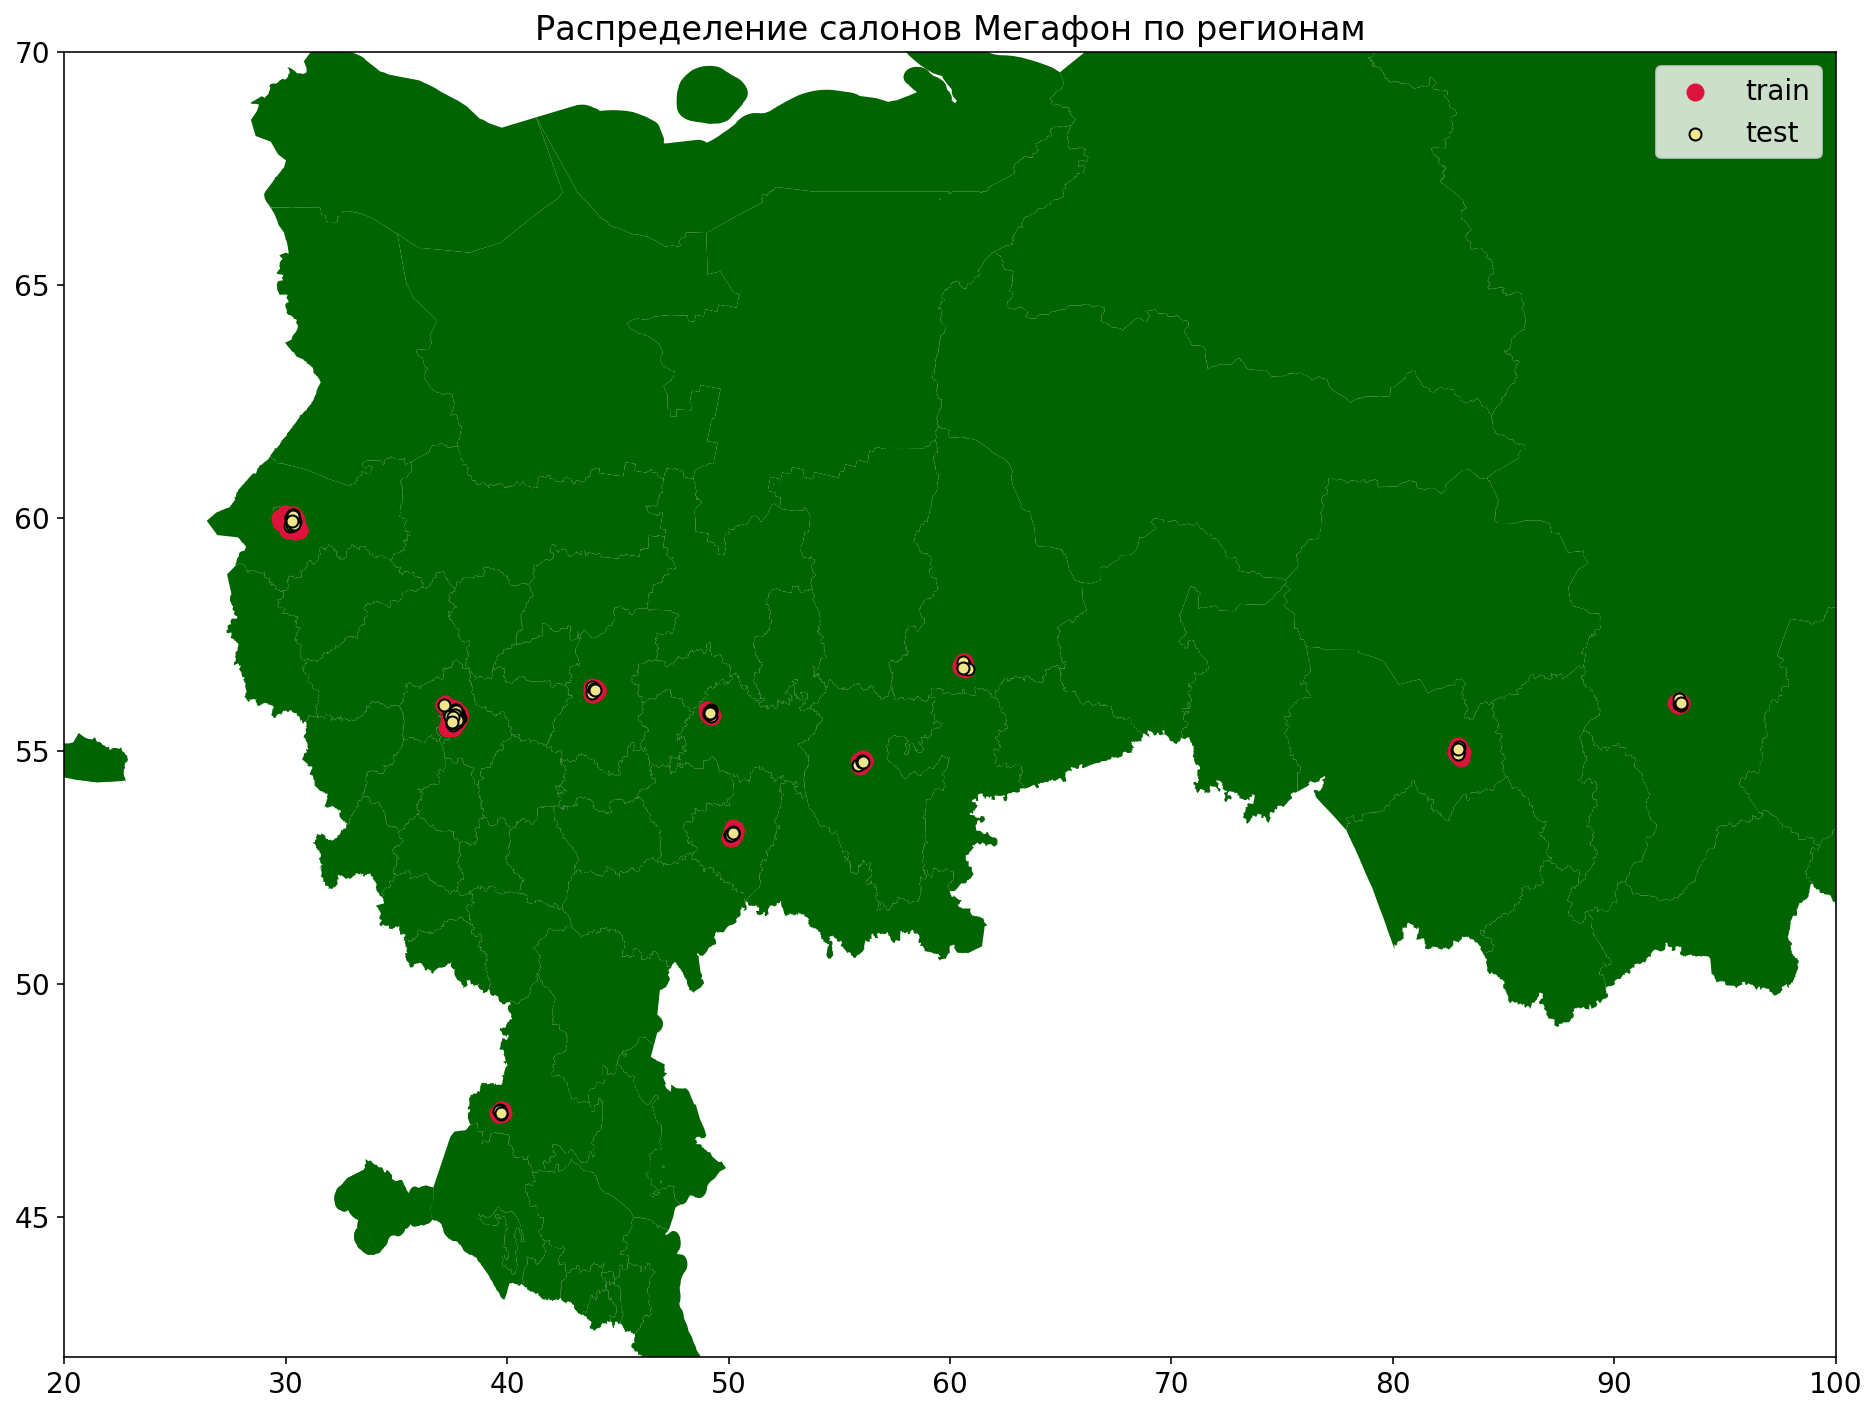

In [33]:
ar.plot(figsize=(16, 12), color='darkgreen')
plt.title("Распределение салонов Мегафон по регионам")
plt.xlim(20,100)
plt.ylim(42, 70)
plt.scatter(train['lon'], train['lat'], c='crimson', s=64, )
plt.scatter(test['lon'], test['lat'], c='khaki', edgecolor='black', s=36)
plt.legend(['train', 'test'])

In [34]:
train['geometry'] = [Point(x, y) for x, y in train[['lon', 'lat']].values]
test['geometry'] = [Point(x, y) for x, y in test[['lon', 'lat']].values]

In [36]:
train_gpd = gpd.sjoin(gpd.GeoDataFrame(train), ar[['name', 'geometry']],  op='within')

In [37]:
train_gpd.head(3)

,point_id,lon,lat,target,city,state,region,geometry,index_right,name
0,ommNZCUV,37.590776,55.848630,-0.348157,Москва,Москва,Центральный федеральный округ,POINT (37.59078 55.84863),64,Москва
1,nMe2LHPb,37.784210,55.750271,1.294206,Москва,Москва,Центральный федеральный округ,POINT (37.78421 55.75027),64,Москва
3,0t2jNYdz,37.704570,55.782020,-1.169339,Москва,Москва,Центральный федеральный округ,POINT (37.70457 55.78202),64,Москва


In [38]:
test_gpd = gpd.sjoin(gpd.GeoDataFrame(test), ar[['name', 'geometry']],  op='within')

In [39]:
new_ar_train = ar.merge(train_gpd.groupby('name').count()['lon'].rename('pickup_cnt').reset_index(),
                        left_on='name',
                        right_on='name').drop('name', axis=1)
new_ar_test = ar.merge(test_gpd.groupby('name').count()['lon'].rename('pickup_cnt').reset_index(),
                        left_on='name',
                        right_on='name').drop('name', axis=1)

In [41]:
!pip install mapclassify

[Text(0.5, 1.0, 'Test')]

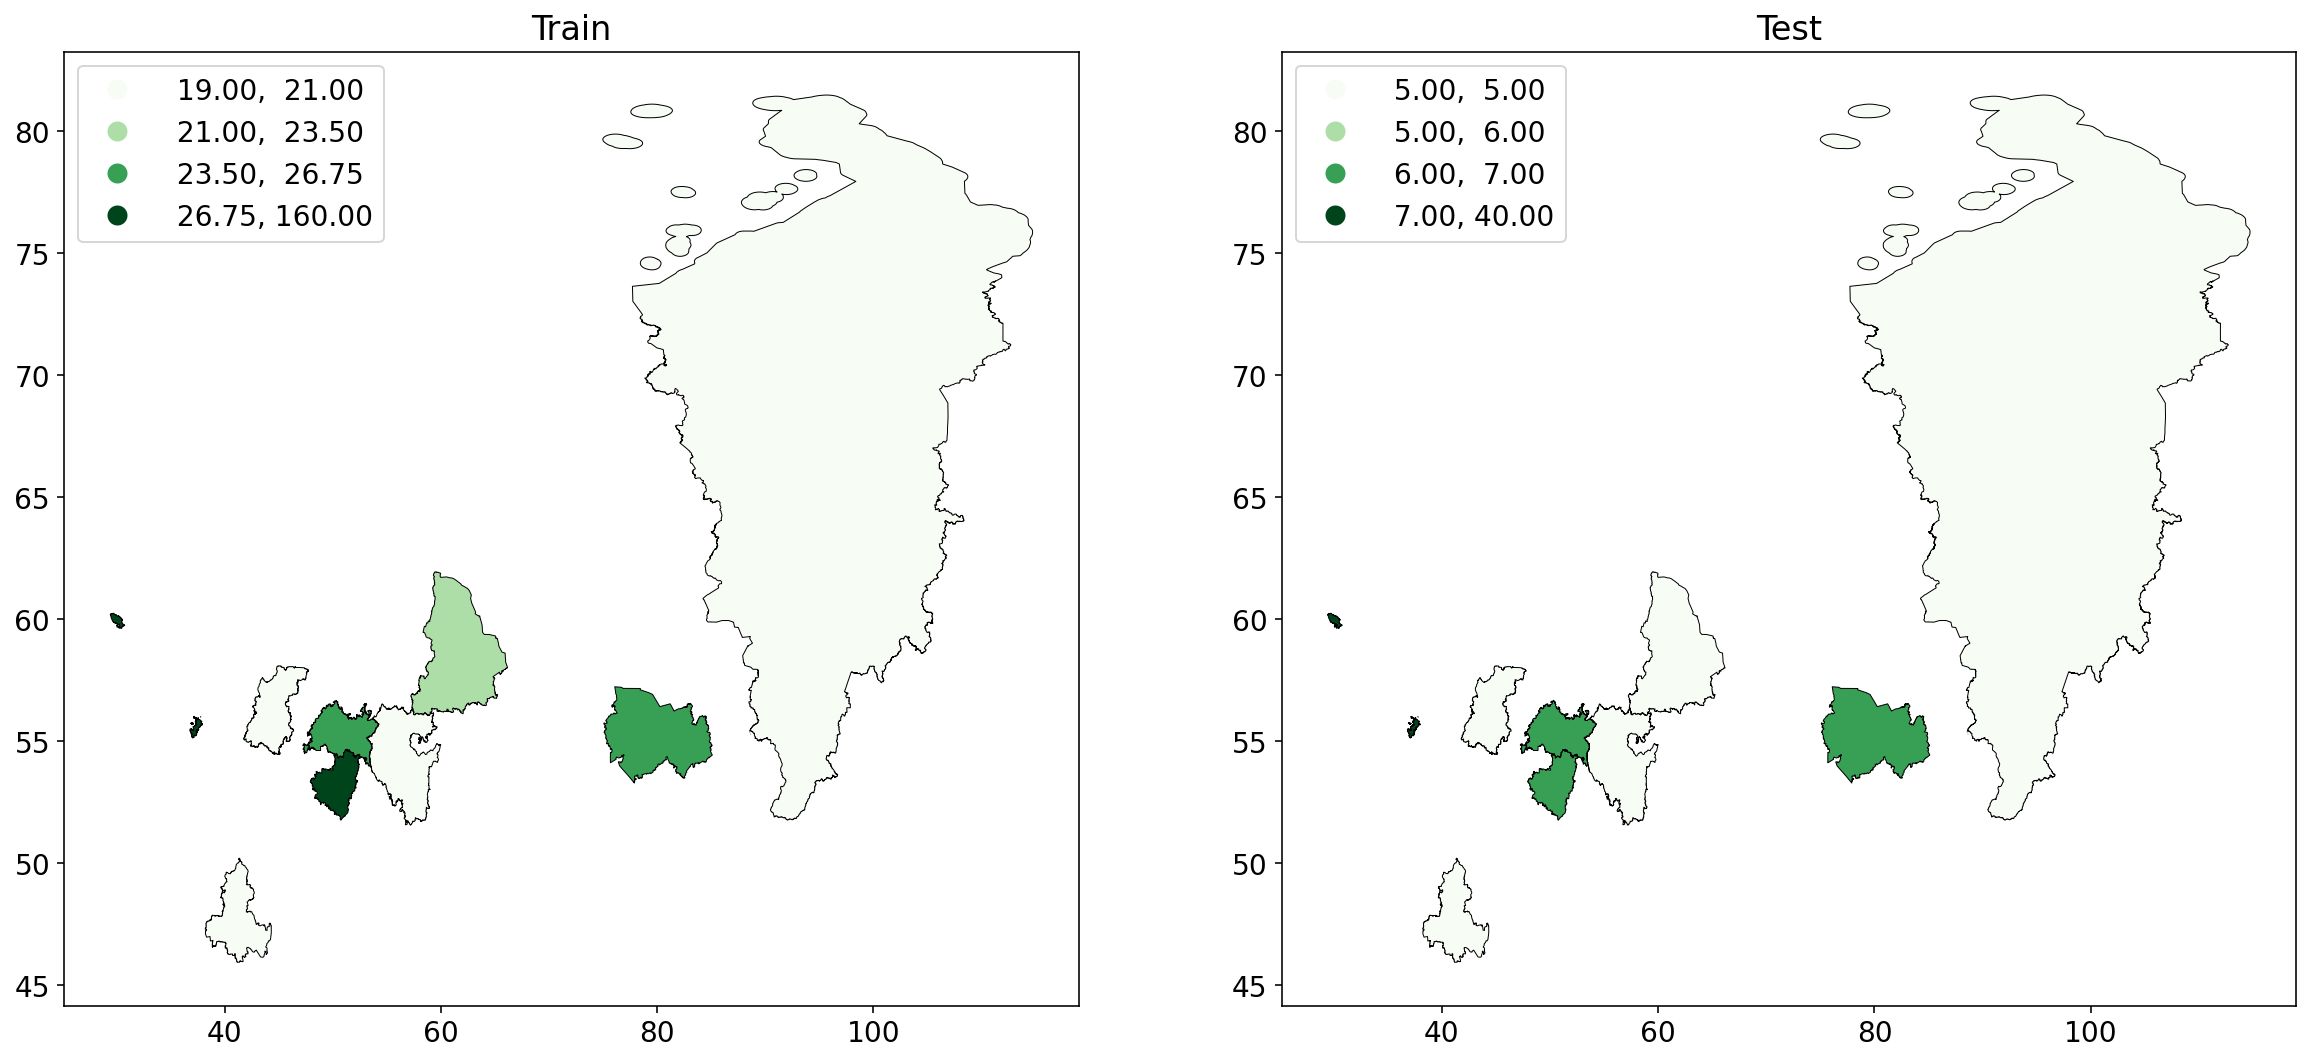

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(20, 15))
new_ar_train.plot('pickup_cnt', ax=ax[0], 
                  edgecolor='black', linewidths=0.5, cmap='Greens', 
                  k=4,  scheme='quantiles', 
                  legend=True, legend_kwds={"loc":'upper left'}
                 )
new_ar_test.plot('pickup_cnt', ax=ax[1], 
                  edgecolor='black', linewidths=0.5, cmap='Greens', 
                  k=4,  scheme='quantiles', 
                  legend=True, legend_kwds={"loc":'upper left'}
                )
ax[0].set(title='Train')
ax[1].set(title='Test')
# ax.legend(arloc='upper left')

In [43]:
train_gpd.groupby('name').count()['lon'].rename('pickup_cnt').reset_index().sort_values(by='pickup_cnt')

,name,pickup_cnt
0,Башкортостан,19
1,Красноярский край,20
3,Нижегородская область,21
5,Ростовская область,21
8,Свердловская область,22
9,Татарстан,25
4,Новосибирская область,26
6,Самарская область,27
7,Санкт-Петербург,83
2,Москва,160


In [44]:
test_gpd.groupby('name').count()['lon'].rename('pickup_cnt').reset_index().sort_values(by='pickup_cnt')

,name,pickup_cnt
0,Башкортостан,5
1,Красноярский край,5
3,Нижегородская область,5
5,Ростовская область,5
8,Свердловская область,5
4,Новосибирская область,7
6,Самарская область,7
9,Татарстан,7
7,Санкт-Петербург,21
2,Москва,40


По распределению салонов ничего необычного нет, большинство из них в Москве и Санкт-Петербурге, а остальные рапсределены равномерно по регионам.

### Добавление признаков

In [45]:
train.city.unique()

array(['Москва', 'Ростов-на-Дону', 'Красноярск', 'Санкт-Петербург', 'Уфа',
       'Казань', 'Екатеринбург', 'Нижний Новгород', 'Колпино',
       'Новосибирск', 'Самара', 'Красное Село', 'Сестрорецк', 'Петергоф',
       'Троицк', 'Зеленоград', 'Щербинка', 'Пушкин', 'Кронштадт',
       'Ломоносов'], dtype=object)

In [46]:
test.city.unique()

array(['Москва', 'Екатеринбург', 'Казань', 'Санкт-Петербург', 'Самара',
       'Новосибирск', 'Нижний Новгород', 'Ростов-на-Дону', 'Уфа',
       'Красноярск', 'Зеленоград', 'Парголово'], dtype=object)

Добавим в данные следующие признаки:
<ol>
    <li>Расстояние до ближайшей ж/д станции</li>
    <li>Расстояние до ближайшей автобусной остановки</li>
    <li>Расстояние до ближайшего банкомата</li>
    <li>Расстояние до центра города</li>
    <li>Расстояние до ближайшего отеля</li>
</ol> 
Везде будет рассчитано расстояние "напрямую", то есть приближенно как шел бы пешеход

area["ISO3166-1"="RU"][admin_level=5];

In [47]:
train_gpd.tail(2)

,point_id,lon,lat,target,city,state,region,geometry,index_right,name
404,fI0HvX5p,50.225666,53.259281,0.300144,Самара,Самарская область,Приволжский федеральный округ,POINT (50.22567 53.25928),18,Самарская область
416,6B6HHnCd,50.121798,53.187213,0.040823,Самара,Самарская область,Приволжский федеральный округ,POINT (50.12180 53.18721),18,Самарская область


In [49]:
!pip install osmnx

     |████████████████████████████████| 102kB 6.9MB/s 
     |████████████████████████████████| 10.3MB 12.9MB/s 
     |████████████████████████████████| 61kB 9.3MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
  Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [50]:
import networkx as nx
import osmnx as ox
ox.config(log_console=True, use_cache=True)
ox.__version__

'1.1.1'

In [53]:
overpass_url = "https://lz4.overpass-api.de/api/interpreter" 

In [54]:
!pip install overpass

In [55]:
import requests
import json
import overpass
from datetime import datetime
from geopy import distance

In [56]:
from datetime import datetime

In [57]:
from sklearn.neighbors import KDTree

def find_nearest_node(tree, gdf, point):
    closest_idx = tree.query([(point.y, point.x)], k=1, return_distance=False)
    nearest_node = gdf.iloc[closest_idx[0]].index.values[0]
    return nearest_node

def closest_item(points, p, default_value):
    'Return (distance, Point.x, Point.y)'
    
    # Значение, если на заданном расстоянии не нашлось нужных объектов
    if points.shape[0] == 0:
        return default_value
    tree = KDTree(points[['y', 'x']], metric='euclidean')
    node = find_nearest_node(tree, points, p)
    fp = points.iloc[node]
    return distance.geodesic((p.y, p.x), (fp.y, fp.x)).km, fp.x, fp.y

def download_feature(query, query_overpass, url="https://lz4.overpass-api.de/api/interpreter"):
    # Пробуем скачать через requests
    response = requests.get(url, params={'data': query})
    if 200 <= response.status_code < 300:
        data = response.json()
        points = pd.DataFrame([(item['lon'], item['lat'], Point(item['lon'], item['lat'])) for item in data['elements']], columns=['x', 'y', 'geometry'])
    # Даем еще один шанс, но через overpass (вообще результаты идентичными получаются, просто попробовал двумя способами)
    else:
        api = overpass.API(endpoint=url)
        response = api.get(query_overpass)
        data = response['features']
        points = pd.DataFrame([(item['geometry']['coordinates'][0], item['geometry']['coordinates'][1], Point(*item['geometry']['coordinates'])) \
                               for item in data], columns=['x', 'y', 'geometry'])
    return points


def download_around_data(req_query, ovp_query, dataset, overpass_url, default_value):
    array = np.zeros((dataset.shape[0], 3))
    num = 0 
    while num < dataset.shape[0]:
        p = dataset['geometry'].values[num]
        try:
            points = download_feature(req_query(p.y, p.x), ovp_query(p.y, p.x), url=overpass_url)
            array[num] = closest_item(points, p, default_value)
            num += 1
            if num % 10 == 0:
                print(f"#{num:>3}/{dataset.shape[0]} {datetime.now().strftime('%d. %B %Y %I:%M%p')}")
        except KeyboardInterrupt:
            break
        except:
            pass
    print(f"#{num:>3}/{dataset.shape[0]} {datetime.now().strftime('%d. %B %Y %I:%M%p')}")
    return array

Скачивать данные дела не простое, постоянно вылетают ошибки на число запросов. Поэтому сделаем функцию для сохранения данных в формате `hdf5`

In [58]:
import h5py 
import os

def write_to_hdf5(path, name, data):
    with h5py.File(path, 'a') as file:
        file.create_dataset(name, data=data)

### Скачивание данных

Дальше будет происходить обкачка данных, чтобы не скачивать данные с сайта OSM из раза в раз. Я сохранил все данные и просто подгружаю их. 

После скачивания каждой фичи она сохраняется в файл формата hdf5. Сделал для каждой отдельно, потому что процесс обкачки шел довольно долго.


Соответственно, ячейки со скачиванием и сохранением закоментированы

Ж/Д станции в радиусе 5 км

In [59]:
rw_rquery = lambda x, y: f'[out:json];(node[railway=station](around:5000, {x}, {y}););out center;'
rw_ovpquery = lambda x, y: f'node[railway=station](around:5000, {x}, {y})'

In [ ]:
# rw_distances_train = download_around_data(rw_rquery, rw_ovpquery, train, overpass_url, default_value=5)
# rw_distances_test = download_around_data(rw_rquery, rw_ovpquery, test, overpass_url, default_value=5)

# 10/107 25. May 2021 01:41AM
# 20/107 25. May 2021 01:41AM
# 30/107 25. May 2021 01:41AM
# 40/107 25. May 2021 01:42AM
# 50/107 25. May 2021 01:42AM
# 60/107 25. May 2021 01:42AM
# 70/107 25. May 2021 01:42AM
# 80/107 25. May 2021 01:42AM
# 90/107 25. May 2021 01:43AM
#100/107 25. May 2021 01:43AM
#107/107 25. May 2021 01:43AM


In [ ]:
# write_to_hdf5('./parsed_data/geo_data_train', 'rw_dist_train', rw_distances_train)
# write_to_hdf5('./parsed_data/geo_data_test', 'rw_dist_test', rw_distances_test)

Банкоматы в радиусе 2 км 

In [62]:
atm_rquery = lambda x, y: f'[out:json];(node[amenity=atm](around:2000, {x}, {y}););out center;'
atm_ovpquery = lambda x, y: f'node[amenity=atm](around:2000, {x}, {y})'

In [63]:
# atm_distances_train = download_around_data(atm_rquery, atm_ovpquery, train, overpass_url, default_value=2)
# atm_distances_test = download_around_data(atm_rquery, atm_ovpquery, test, overpass_url, default_value=2)

In [ ]:
# write_to_hdf5('./parsed_data/geo_data_train', 'atm_dist_train', atm_distances_train)
# write_to_hdf5('./parsed_data/geo_data_test', 'atm_dist_test', atm_distances_test)

Автобусные остановки в 2 км

In [61]:
# bus_rquery = lambda x, y: f'[out:json];(node[highway=bus_stop](around:500, {x}, {y}););out center;'
# bus_ovpquery = lambda x, y: f'node[highway=bus_stop](around:500, {x}, {y})'

In [64]:
# bus_distances_train = download_around_data(bus_rquery, bus_ovpquery, train, overpass_url, default_value=2)
# bus_distances_test = download_around_data(bus_rquery, bus_ovpquery, test, overpass_url, default_value=2)

In [ ]:
# write_to_hdf5('./parsed_data/geo_data_train', 'bus_dist_train', bus_distances_train)
# write_to_hdf5('./parsed_data/geo_data_test', 'bus_dist_test', bus_distances_test)

Раз уж предложенная гипотеза содержит факт, что человек приезжий, то ищем еще ближайшее расстояние до гостиницы в радиусе 2 км

In [65]:
hotel_rquery = lambda x, y: f'[out:json];(node[tourism=hotel](around:2000, {x}, {y}););out center;'
hotel_ovpquery = lambda x, y: f'node[tourism=hotel](around:2000, {x}, {y})'

In [ ]:
# hotel_train = download_around_data(hotel_rquery, hotel_ovpquery, train, overpass_url, default_value=2)
# hotel_test = download_around_data(hotel_rquery, hotel_ovpquery, test, overpass_url, default_value=2)

# 10/107 25. May 2021 08:03PM
# 20/107 25. May 2021 08:04PM
# 30/107 25. May 2021 08:04PM
# 40/107 25. May 2021 08:05PM
# 50/107 25. May 2021 08:05PM
# 60/107 25. May 2021 08:06PM
# 70/107 25. May 2021 08:07PM
# 80/107 25. May 2021 08:08PM
# 90/107 25. May 2021 08:08PM
#100/107 25. May 2021 08:09PM
#107/107 25. May 2021 08:09PM


In [66]:
# write_to_hdf5('./parsed_data/geo_data_train', 'hotel_train', hotel_train)
# write_to_hdf5('./parsed_data/geo_data_test', 'hotel_test', hotel_test)

Расстояние до центра города

тут нужно учитывать, что снова могут попастся не `city`, а `town`

In [67]:
def download_city_center(req_query, ovp_query, dataset, overpass_url, default_value=None):
    array = np.zeros((dataset.shape[0], 3))
    num = 0 
    while num < dataset.shape[0]:
        p = dataset['geometry'].values[num]
        city = dataset['city'].values[num]
        try:
            points = download_feature(req_query(city, 'city'), ovp_query(city, 'city'), url=overpass_url)
            if points.shape[0] == 0:
                points = download_feature(req_query(city, 'town'), ovp_query(city, 'town'), url=overpass_url)

            # Тут предполагается, что найденный ответ должен быть один 
            if points.shape[0] == 1:
                fp = points['geometry'].values[0]
                array[num] = distance.geodesic((p.y, p.x), (fp.y, fp.x)).km, fp.x, fp.y
            
            else:
                print(f"Bad request {num}")
            num += 1
            if num % 10 == 0:
                print(f"#{num:>3}/{dataset.shape[0]} {datetime.now().strftime('%d. %B %Y %I:%M%p')}")
        except KeyboardInterrupt:
            break
        except:
            pass
    print(f"#{num:>3}/{dataset.shape[0]} {datetime.now().strftime('%d. %B %Y %I:%M%p')}")
    return array

In [68]:
center_rquery = lambda name, kind: f'[out:json];(node[place={kind}]["name"="{name}"];);out center;'
center_ovpquery = lambda name, kind: f'node[place={kind}]["name"="{name}"]'

In [70]:
# city_train = download_city_center(center_rquery, center_ovpquery, train, overpass_url)
# city_test = download_city_center(center_rquery, center_ovpquery, test, overpass_url)

In [69]:
# write_to_hdf5('./parsed_data/geo_data_train', 'center_train', city_train)
# write_to_hdf5('./parsed_data/geo_data_test', 'center_test', city_test)

Теперь добавим несколько признаков с буферными зонами. Посмотрим сколько кафе, банкоматов и отелей попало в зоны 200, 500 и 1000 метров

In [71]:
atm_rquery = lambda r, x, y: f'[out:json];(node[amenity=atm](around:{r}, {x}, {y}););out center;'
atm_ovpquery = lambda r, x, y: f'node[amenity=atm](around:{r}, {x}, {y})'

hotel_rquery = lambda r, x, y: f'[out:json];(node[tourism=hotel](around:{r}, {x}, {y}););out center;'
hotel_ovpquery = lambda r, x, y: f'node[tourism=hotel](around:{r}, {x}, {y})'

cafe_rquery = lambda r, x, y: f'[out:json];(node[amenity=cafe](around:{r}, {x}, {y}););out center;'
cafe_ovpquery = lambda r, x, y: f'node[amenity=cafe](around:{r}, {x}, {y})'

def count_staff_in_buffer(req_query, ovp_query, dataset, overpass_url, radius):
    array = []
    num = 0 
    while num < dataset.shape[0]:
        p = dataset['geometry'].values[num]
        try:
            points = download_feature(req_query(radius, p.y, p.x), ovp_query(radius, p.y, p.x), url=overpass_url)
            array.append(points)
            num += 1
            if num % 5 == 0:
                print(f"#{num:>3}/{dataset.shape[0]} {datetime.now().strftime('%d. %B %Y %I:%M%p')}")
        except KeyboardInterrupt:
            break
        except:
            pass
    print(f"#{num:>3}/{dataset.shape[0]} {datetime.now().strftime('%d. %B %Y %I:%M%p')}")
    return array

train

In [ ]:
radiuses = [200, 500, 1000]

# atms_train = []
# for radius in radiuses:
#     print(f"Buff zone: {radius}")
#     tmp = count_staff_in_buffer(atm_rquery, atm_ovpquery, train, overpass_url, radius)
#     atms_train.append(tmp)
#     print()
    

# cafes_train = []
# for radius in radiuses:
#     print(f"Buff zone: {radius}")
#     tmp = count_staff_in_buffer(cafe_rquery, cafe_ovpquery, train, overpass_url, radius)
#     cafes.append(tmp)
#     print()
    
# hotels_train = []
# for radius in radiuses:
#     print(f"Buff zone: {radius}")
#     tmp = count_staff_in_buffer(hotel_rquery, hotel_ovpquery, train, overpass_url, radius)
#     hotels_train.append(tmp)
#     print()

test

In [ ]:
radiuses = [200, 500, 1000]

# atms_test = []
# for radius in radiuses:
#     print(f"Buff zone: {radius}")
#     tmp = count_staff_in_buffer(atm_rquery, atm_ovpquery, test, overpass_url, radius)
#     atms_test.append(tmp)
#     print()
    

Buff zone: 200
#  5/107 25. May 2021 02:22AM
# 10/107 25. May 2021 02:22AM
# 15/107 25. May 2021 02:22AM
# 20/107 25. May 2021 02:22AM
# 25/107 25. May 2021 02:22AM
# 30/107 25. May 2021 02:23AM
# 35/107 25. May 2021 02:23AM
# 40/107 25. May 2021 02:23AM
# 45/107 25. May 2021 02:23AM
# 50/107 25. May 2021 02:23AM
# 55/107 25. May 2021 02:23AM
# 60/107 25. May 2021 02:23AM
# 65/107 25. May 2021 02:23AM
# 70/107 25. May 2021 02:23AM
# 75/107 25. May 2021 02:23AM
# 80/107 25. May 2021 02:23AM
# 85/107 25. May 2021 02:23AM
# 90/107 25. May 2021 02:23AM
# 95/107 25. May 2021 02:23AM
#100/107 25. May 2021 02:23AM
#105/107 25. May 2021 02:23AM
#107/107 25. May 2021 02:24AM

Buff zone: 500
#  5/107 25. May 2021 02:24AM
# 10/107 25. May 2021 02:24AM
# 15/107 25. May 2021 02:24AM
# 20/107 25. May 2021 02:24AM
# 25/107 25. May 2021 02:24AM
# 30/107 25. May 2021 02:24AM
# 35/107 25. May 2021 02:24AM
# 40/107 25. May 2021 02:24AM
# 45/107 25. May 2021 02:25AM
# 50/107 25. May 2021 02:25AM
# 55/107 

In [ ]:
# cafes_test = []
# for radius in radiuses:
#     print(f"Buff zone: {radius}")
#     tmp = count_staff_in_buffer(cafe_rquery, cafe_ovpquery, test, overpass_url, radius)
#     cafes_test.append(tmp)
#     print()

Buff zone: 200
#  5/107 25. May 2021 02:28AM
# 10/107 25. May 2021 02:28AM
# 15/107 25. May 2021 02:28AM
# 20/107 25. May 2021 02:28AM
# 25/107 25. May 2021 02:29AM
# 30/107 25. May 2021 02:29AM
# 35/107 25. May 2021 02:29AM
# 40/107 25. May 2021 02:29AM
# 45/107 25. May 2021 02:29AM
# 50/107 25. May 2021 02:29AM
# 55/107 25. May 2021 02:29AM
# 60/107 25. May 2021 02:29AM
# 65/107 25. May 2021 02:29AM
# 70/107 25. May 2021 02:29AM
# 75/107 25. May 2021 02:29AM
# 80/107 25. May 2021 02:29AM
# 85/107 25. May 2021 02:30AM
# 90/107 25. May 2021 02:30AM
# 95/107 25. May 2021 02:30AM
#100/107 25. May 2021 02:30AM
#105/107 25. May 2021 02:31AM
#107/107 25. May 2021 02:31AM

Buff zone: 500
#  5/107 25. May 2021 02:31AM
# 10/107 25. May 2021 02:31AM
# 15/107 25. May 2021 02:32AM
# 20/107 25. May 2021 02:32AM
# 25/107 25. May 2021 02:33AM
# 30/107 25. May 2021 02:33AM
# 35/107 25. May 2021 02:33AM
# 40/107 25. May 2021 02:33AM
# 45/107 25. May 2021 02:33AM
# 50/107 25. May 2021 02:33AM
# 55/107 

In [ ]:
# hotels_test = []
# for radius in radiuses:
#     print(f"Buff zone: {radius}")
#     tmp = count_staff_in_buffer(hotel_rquery, hotel_ovpquery, test, overpass_url, radius)
#     hotels_test.append(tmp)
#     print()

Buff zone: 200
#  5/107 25. May 2021 02:37AM
# 10/107 25. May 2021 02:37AM
# 15/107 25. May 2021 02:37AM
# 20/107 25. May 2021 02:37AM
# 25/107 25. May 2021 02:37AM
# 30/107 25. May 2021 02:37AM
# 35/107 25. May 2021 02:37AM
# 40/107 25. May 2021 02:37AM
# 45/107 25. May 2021 02:37AM
# 50/107 25. May 2021 02:37AM
# 55/107 25. May 2021 02:37AM
# 60/107 25. May 2021 02:37AM
# 65/107 25. May 2021 02:37AM
# 70/107 25. May 2021 02:37AM
# 75/107 25. May 2021 02:37AM
# 80/107 25. May 2021 02:37AM
# 85/107 25. May 2021 02:37AM
# 90/107 25. May 2021 02:38AM
# 95/107 25. May 2021 02:38AM
#100/107 25. May 2021 02:38AM
#105/107 25. May 2021 02:38AM
#107/107 25. May 2021 02:38AM

Buff zone: 500
#  5/107 25. May 2021 02:38AM
# 10/107 25. May 2021 02:38AM
# 15/107 25. May 2021 02:38AM
# 20/107 25. May 2021 02:38AM
# 25/107 25. May 2021 02:38AM
# 30/107 25. May 2021 02:38AM
# 35/107 25. May 2021 02:38AM
# 40/107 25. May 2021 02:38AM
# 45/107 25. May 2021 02:38AM
# 50/107 25. May 2021 02:38AM
# 55/107 

In [ ]:
# features_train = np.zeros((3, train.shape[0], 3)) # [radius, N_samples, features_points]
# for num, feature in enumerate([atms_train, cafes_train, hotels_train]):
#     for ns in range(test.shape[0]):
#         for r in range(len(radiuses)):
#             features_train[num, ns, r] = len(feature[r][ns])

In [ ]:
# write_to_hdf5('./parsed_data/geo_data_train', 'buff_area_train', features_train)

In [ ]:
# features = np.zeros((3, test.shape[0], 3)) # [radius, N_samples, features_points]
# for num, feature in enumerate([atms_test, cafes_test, hotels_test]):
#     for ns in range(test.shape[0]):
#         for r in range(len(radiuses)):
#             features[num, ns, r] = len(feature[r][ns])

In [ ]:
# write_to_hdf5('./parsed_data/geo_data_test', 'buff_area_test', features)

#### Все, все данные скачаны


### Здесь, считываем скачаннные данные

In [88]:
!mkdir parsed_data

!wget https://raw.githubusercontent.com/AlexLoner/2021-2-Atom-ML-A-Lukianov/main/kaggle_mf_geo_hw7/parsed_data/atms_train.pickle -O ./parsed_data/atms_train.pickle
!wget https://raw.githubusercontent.com/AlexLoner/2021-2-Atom-ML-A-Lukianov/main/kaggle_mf_geo_hw7/parsed_data/cafes_train.pickle -O ./parsed_data/cafes_train.pickle
!wget https://raw.githubusercontent.com/AlexLoner/2021-2-Atom-ML-A-Lukianov/main/kaggle_mf_geo_hw7/parsed_data/hotels_train.pickle -O ./parsed_data/hotels_train.pickle

!wget https://raw.githubusercontent.com/AlexLoner/2021-2-Atom-ML-A-Lukianov/main/kaggle_mf_geo_hw7/parsed_data/atms_test.pickle -O ./parsed_data/atms_test.pickle
!wget https://raw.githubusercontent.com/AlexLoner/2021-2-Atom-ML-A-Lukianov/main/kaggle_mf_geo_hw7/parsed_data/cafes_test.pickle -O ./parsed_data/cafes_test.pickle
!wget https://raw.githubusercontent.com/AlexLoner/2021-2-Atom-ML-A-Lukianov/main/kaggle_mf_geo_hw7/parsed_data/hotels_test.pickle -O ./parsed_data/hotels_test.pickle

!wget https://raw.githubusercontent.com/AlexLoner/2021-2-Atom-ML-A-Lukianov/main/kaggle_mf_geo_hw7/parsed_data/geo_data_train -O ./parsed_data/geo_data_train
!wget https://raw.githubusercontent.com/AlexLoner/2021-2-Atom-ML-A-Lukianov/main/kaggle_mf_geo_hw7/parsed_data/geo_data_test -O ./parsed_data/geo_data_test

mkdir: cannot create directory ‘parsed_data’: File exists
--2021-05-26 11:46:24--  https://raw.githubusercontent.com/AlexLoner/2021-2-Atom-ML-A-Lukianov/main/kaggle_mf_geo_hw7/parsed_data/atms_train.pickle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 912986 (892K) [application/octet-stream]
Saving to: ‘./parsed_data/atms_train.pickle’

./parsed_data/atms_ 100%[===================>] 891.59K  --.-KB/s    in 0.04s   

2021-05-26 11:46:24 (22.4 MB/s) - ‘./parsed_data/atms_train.pickle’ saved [912986/912986]

--2021-05-26 11:46:24--  https://raw.githubusercontent.com/AlexLoner/2021-2-Atom-ML-A-Lukianov/main/kaggle_mf_geo_hw7/parsed_data/cafes_train.pickle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.1

In [89]:
# Блок, чтобы не пересчитывать сохраненные данные
import pickle 


with open('./parsed_data/atms_train.pickle', 'rb') as pkl:
    atms_train = pickle.load(pkl)

with open('./parsed_data/cafes_train.pickle', 'rb') as pkl:
    cafes_train = pickle.load(pkl)

with open('./parsed_data/hotels_train.pickle', 'rb') as pkl:
    hotels_train = pickle.load(pkl)

with open('./parsed_data/atms_test.pickle', 'rb') as pkl:
    atms_test = pickle.load(pkl)

with open('./parsed_data/cafes_test.pickle', 'rb') as pkl:
    cafes_test = pickle.load(pkl)

with open('./parsed_data/hotels_test.pickle', 'rb') as pkl:
    hotels_test = pickle.load(pkl)


In [90]:
def flatten_points(obj, size, prefix=''):
    df = pd.DataFrame(index=range(size), columns=[f"{prefix}_poly_200", f'{prefix}_poly_500', f'{prefix}_poly_1000'])
    for (col, item) in enumerate(obj):
        for row in range(size):
            df.iloc[row, col] = item[row][['y', 'x']].values
    return df
        

In [91]:
atms_train = flatten_points(atms_train, train.shape[0], 'atm')
atms_test = flatten_points(atms_test, test.shape[0], 'atm')

cafes_train = flatten_points(cafes_train, train.shape[0], 'cafe')
cafes_test = flatten_points(cafes_test, test.shape[0], 'cafe')

hotels_train = flatten_points(hotels_train, train.shape[0], 'hotel')
hotels_test = flatten_points(hotels_test, test.shape[0], 'hotel')

Собираем все данные вместе, все записи делались в следующем формате (дистанция [км], х, у). Исключение составляет подсчет количества объектов в буферных зонах

In [92]:
def collect_data_to_dict(filename, coords=False):
    with h5py.File(filename, 'r') as file:
        dct = dict()
        for key in file:
            new_key = key.split('_')[0]
            if new_key == 'buff':
                _tmp = file[key][()]
                for name in ['atm', 'cafe', 'hotel']:
                    dct[f"{name}_200"] = file[key][0, :, 0]
                    dct[f"{name}_500"] = file[key][1, :, 1]
                    dct[f"{name}_1000"] = file[key][2, :, 2]
            else:
                dct[new_key] = file[key][:, 0]
                if coords:
                    dct[f"{new_key}_geometry"] = [Point(x, y) for x, y in zip(file[key][:, 1], file[key][:, 2])]
    return dct 

Интересно посмотреть как выглядят буферные зоны для наших объектов. Попробуем построить некоторые из них

In [93]:
full_train = collect_data_to_dict('./parsed_data/geo_data_train', True)
full_test = collect_data_to_dict('./parsed_data/geo_data_test', True)

In [94]:
full_train = pd.DataFrame.from_dict(full_train)
full_test = pd.DataFrame.from_dict(full_test)

Подсоединим названия городов и начальные позиции объектов, чтобы было проще группировать

In [95]:
full_train['city'] = train['city']
full_test['city'] = test['city']

In [96]:
full_train['geometry'] = train['geometry']
full_test['geometry'] = test['geometry']

In [97]:
full_test.head(3)

,atm,atm_geometry,atm_200,atm_500,atm_1000,cafe_200,cafe_500,cafe_1000,hotel_200,hotel_500,hotel_1000,bus,bus_geometry,center,center_geometry,hotel,hotel_geometry,rw,rw_geometry,city,geometry
0,0.116586,POINT (37.6800304 55.7472466),3.0,10.0,4.0,3.0,10.0,4.0,3.0,10.0,4.0,0.168330,POINT (37.6815138 55.7465359),4.012063,POINT (37.6174943 55.7504461),0.352425,POINT (37.6773424 55.7457637),0.162890,POINT (37.6833543 55.7471909),Москва,POINT (37.68124 55.74804)
1,0.016386,POINT (60.5809823 56.7960017),5.0,1.0,1.0,5.0,1.0,1.0,5.0,1.0,1.0,0.200557,POINT (60.5807884 56.7976598),5.096741,POINT (60.60825 56.839104),0.805317,POINT (60.5897201 56.8012389),2.210515,POINT (60.6097872 56.8078202),Екатеринбург,POINT (60.58091 56.79586)
2,0.089264,POINT (37.5987336 55.7821559),3.0,96.0,4.0,3.0,96.0,4.0,3.0,96.0,4.0,0.021236,POINT (37.598941 55.7814062),3.639877,POINT (37.6174943 55.7504461),0.032240,POINT (37.5984085 55.7816224),0.166485,POINT (37.6012035 55.7810309),Москва,POINT (37.59861 55.78136)


In [98]:
import folium

Для начала посмотрим как внутри города распределены салоны, для примера возьмем Екатеринбург

In [99]:
ekat_train = full_train[full_train['city'] == 'Екатеринбург'][['geometry']]
ekat_test = full_test[full_test['city'] == 'Екатеринбург'][['geometry']]

In [100]:
start_location = full_test[full_test['city'] == 'Екатеринбург']['center_geometry'].values[0]

In [101]:
m = folium.Map(location=[start_location.y, start_location.x], zoom_start=12)

# Раскрасим все тестовые метки зеленым цветом
for point in ekat_test['geometry'].values:
    folium.Marker(
        location=(point.y, point.x), 
        popup='Тут должен быть салон Мегафона (Test)', 
        tooltip=f'({point.y}, {point.x})',
        icon=folium.Icon(color="green")
    ).add_to(m)

# Раскрасим все тестовые метки синим цветом
for point in ekat_train['geometry'].values:
    folium.Marker(
        location=(point.y, point.x), 
        popup='Тут должен быть салон Мегафона (Train)', 
        tooltip=f'({point.y}, {point.x})',
        icon=folium.Icon(color="blue")
    ).add_to(m)
    
folium.Marker(
        location=(start_location.y, start_location.x), 
        popup='если верить OSM', 
        tooltip=f'Центр Города',
        icon=folium.Icon(color="red")
    ).add_to(m)
m

Теперь посмотрим на объекты внутри буферных зон в Казани для 200 и 500 метров

In [102]:
kaz_train = full_train[full_train['city'] == 'Казань'][['geometry']]
kaz_test = full_test[full_test['city'] == 'Казань'][['geometry']]

In [103]:
start_location = full_test[full_test['city'] == 'Казань']['center_geometry'].values[0]

Индексы, по которым будем доставать данные об объектах в буферных зонах

In [104]:
indx_train = kaz_train.index.values
indx_test = kaz_test.index.values

In [105]:
cafes_test.iloc[indx_test]

,cafe_poly_200,cafe_poly_500,cafe_poly_1000
4,"[[55.7479027, 49.2107078], [55.7478976, 49.210...","[[55.7479027, 49.2107078], [55.7478976, 49.210...","[[55.7479027, 49.2107078], [55.7496202, 49.228..."
6,[],[],"[[55.864726, 49.2253308], [55.865017, 49.22440..."
10,"[[55.8362213, 49.1030107]]","[[55.836199, 49.1037465], [55.8367735, 49.1047...","[[55.8279132, 49.104523], [55.8313087, 49.0906..."
38,"[[55.8620386, 49.2209926], [55.8634731, 49.221...","[[55.8596817, 49.2152604], [55.8620386, 49.220...","[[55.8596817, 49.2152604], [55.8620386, 49.220..."
68,"[[55.7867362, 49.1237086], [55.7878087, 49.122...","[[55.7890072, 49.1236912], [55.7880624, 49.119...","[[55.7954261, 49.1236839], [55.7921028, 49.132..."
70,"[[55.8251519, 49.1526585], [55.8250438, 49.154...","[[55.8251519, 49.1526585], [55.8250438, 49.154...","[[55.8295023, 49.1468828], [55.8251519, 49.152..."
75,"[[55.8164975, 49.1818133], [55.81732, 49.18237...","[[55.814069, 49.1809078], [55.8164975, 49.1818...","[[55.814069, 49.1809078], [55.8164975, 49.1818..."


In [106]:
m = folium.Map(location=[start_location.y, start_location.x], zoom_start=15)

# Раскрасим все тестовые метки зеленым цветом
for (num, point) in enumerate(kaz_test['geometry'].values):
    
    # салоны
    folium.Marker(
        location=(point.y, point.x), 
        popup='Тут должен быть салон Мегафона (Test)', 
        tooltip=f'({point.y}, {point.x})',
        icon=folium.Icon(color="green")
    ).add_to(m)
    
    # Рисуем зоны
    for r in [500, 200]:
        folium.Circle(
            radius=r, weight=2,
            fill_color='lightgreen', color='green',
            location=(point.y, point.x), 
        ).add_to(m)
    
# Объекты в кружках)
for color, obj_type, obj_name in zip(
    ['purple', 'lightred', 'gray'], 
    [hotels_test.iloc[indx_test], cafes_test.iloc[indx_test], atms_test.iloc[indx_test]],
    ['hotel', 'cafe', 'atm']
):
    for cols in range(2): # Буферные зоны 

        for pp in [_j for _i in obj_type.iloc[:, cols] for _j in _i]: # Разворачиваем координаты для отдельных объектов в один массив 
            folium.Marker(
                location=(pp[0], pp[1]), 
                tooltip=obj_name,
                icon=folium.Icon(color=color)
            ).add_to(m)

# Раскрасим все тестовые метки синим цветом
for point in kaz_train['geometry'].values:
    folium.Marker(
        location=(point.y, point.x), 
        popup='Тут должен быть салон Мегафона (Train)', 
        tooltip=f'({point.y}, {point.x})',
        icon=folium.Icon(color="blue")
    ).add_to(m)
    for r in [500, 200]:
        folium.Circle(
            radius=r,  weight=2,
            fill_color='lightblue', color='blue',
            location=(point.y, point.x), 
        ).add_to(m)

# Объекты в кружках) для train 
for color, obj_type, obj_name in zip(
    ['purple', 'lightred', 'gray'], 
    [hotels_train.iloc[indx_train], cafes_train.iloc[indx_train], atms_train.iloc[indx_train]],
    ['hotel', 'cafe', 'atm']
):
    for cols in range(2): # Буферные зоны 

        for pp in [_j for _i in obj_type.iloc[:, cols] for _j in _i]: # Разворачиваем координаты для отдельных объектов в один массив 
            folium.Marker(
                location=(pp[0], pp[1]), 
                tooltip=obj_name,
                icon=folium.Icon(color=color)
            ).add_to(m)
        
    
    
folium.Marker(
        location=(start_location.y, start_location.x), 
        popup='если верить OSM', 
        tooltip=f'Центр Города',
        icon=folium.Icon(color="red")
    ).add_to(m)


In [ ]:
m

Еще построим распределение ближайших объектов в этот раз для Новосибирска в радиусе 2 км (если еще 5км для жд станций брать, то получется не наглядно)

In [107]:
nsk_train = full_train[full_train['city'] == 'Новосибирск'][['atm_geometry', 'geometry', 'hotel_geometry']]
nsk_test = full_test[full_test['city'] == 'Новосибирск'][['atm_geometry', 'geometry', 'hotel_geometry']]

In [108]:
start_location = full_test[full_test['city'] == 'Новосибирск']['center_geometry'].values[0]

In [109]:
nsk_test

,atm_geometry,geometry,hotel_geometry
18,POINT (82.961225 55.0757894),POINT (82.96360 55.08110),POINT (82.96734960000001 55.0831976)
23,POINT (82.87858559999999 55.0100346),POINT (82.87474 55.01131),POINT (2 2)
34,POINT (82.93377940000001 55.0319545),POINT (82.93665 55.02888),POINT (82.932847 55.032908)
60,POINT (82.9358306 54.9648114),POINT (82.93822 54.96401),POINT (2 2)
67,POINT (82.9358306 54.9648114),POINT (82.93677 54.96505),POINT (2 2)
69,POINT (82.92910379999999 54.9390308),POINT (82.92328 54.94169),POINT (2 2)
91,POINT (82.9153534 55.0313417),POINT (82.91905 55.02964),POINT (82.9227527 55.0354804)


Надо будет еще исключать значения типо Point(2,2), так заполнились данные, то есть в радиусе 2х км такого объекта нет

In [111]:
m = folium.Map(location=[start_location.y, start_location.x], zoom_start=12)

# Раскрасим все тестовые метки зеленым цветом
for (num, objs) in enumerate(nsk_test.values):
    atm, point, hotel = objs
    # салоны
    folium.Marker(
        location=(point.y, point.x), 
        popup='Тут должен быть салон Мегафона (Test)', 
        tooltip=f'({point.y}, {point.x})',
        icon=folium.Icon(color="green")
    ).add_to(m)
    
    if atm.x > 2:
        folium.Marker(
            location=(atm.y, atm.x), 
            tooltip='ATM',
            icon=folium.Icon(color="beige")
        ).add_to(m)
    if hotel.x > 2:
        folium.Marker(
            location=(hotel.y, hotel.x), 
            tooltip='Hotel',
            icon=folium.Icon(color="purple")
        ).add_to(m)
    
    # Рисуем зоны
    for r in [2000]:
        folium.Circle(
            radius=r, weight=2,
            fill_color='lightgreen', color='green',
            location=(point.y, point.x), 
        ).add_to(m)

# Раскрасим все тестовые метки синим цветом
for (num, objs) in enumerate(nsk_train.values):
    atm, point, hotel = objs
    folium.Marker(
        location=(point.y, point.x), 
        popup='Тут должен быть салон Мегафона (Train)', 
        tooltip=f'({point.y}, {point.x})',
        icon=folium.Icon(color="blue")
    ).add_to(m)
    
    if atm.x > 2:
        folium.Marker(
            location=(atm.y, atm.x), 
            tooltip='ATM',
            icon=folium.Icon(color="beige")
        ).add_to(m)
    if hotel.x > 2:
        folium.Marker(
            location=(hotel.y, hotel.x), 
            tooltip='Hotel',
            icon=folium.Icon(color="purple")
        ).add_to(m)
    
    for r in [2000]:
        folium.Circle(
            radius=r,  weight=2,
            fill_color='lightblue', color='blue',
            location=(point.y, point.x), 
        ).add_to(m)


    
folium.Marker(
        location=(start_location.y, start_location.x), 
        popup='если верить OSM', 
        tooltip=f'Центр Города',
        icon=folium.Icon(color="red")
    ).add_to(m)


In [ ]:
m

Вспоминаем про kaggle, тут при сборке нужных данных, наверное не стоит возвращать сами координаты

In [112]:
dct_train = collect_data_to_dict('./parsed_data/geo_data_train', False)
dct_test = collect_data_to_dict('./parsed_data/geo_data_test', False)

In [113]:
train_features = pd.DataFrame.from_dict(dct_train)
test_features = pd.DataFrame.from_dict(dct_test)

In [114]:
train.head()

,point_id,lon,lat,target,city,state,region,geometry
0,ommNZCUV,37.590776,55.848630,-0.348157,Москва,Москва,Центральный федеральный округ,POINT (37.59078 55.84863)
1,nMe2LHPb,37.784210,55.750271,1.294206,Москва,Москва,Центральный федеральный округ,POINT (37.78421 55.75027)
2,ZgodVRqB,39.635721,47.213330,-1.039679,Ростов-на-Дону,Ростовская область,Южный федеральный округ,POINT (39.63572 47.21333)
3,0t2jNYdz,37.704570,55.782020,-1.169339,Москва,Москва,Центральный федеральный округ,POINT (37.70457 55.78202)
4,U27W4QJ7,37.643983,55.730188,-0.088837,Москва,Москва,Центральный федеральный округ,POINT (37.64398 55.73019)


In [115]:
train_features = pd.concat((train_features, train.reset_index()[['lon', 'lat']]), axis=1)

In [116]:
train_features.head()

,atm,atm_200,atm_500,atm_1000,cafe_200,cafe_500,cafe_1000,hotel_200,hotel_500,hotel_1000,bus,center,hotel,rw,lon,lat
0,0.556783,0.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,4.0,0.025172,11.059296,0.260928,0.167681,37.590776,55.848630
1,0.028543,3.0,5.0,1.0,3.0,5.0,1.0,3.0,5.0,1.0,0.045782,10.468821,0.868314,0.176055,37.784210,55.750271
2,0.604054,0.0,3.0,3.0,0.0,3.0,3.0,0.0,3.0,3.0,0.067449,5.803464,0.796264,2.551461,39.635721,47.213330
3,0.008631,5.0,21.0,3.0,5.0,21.0,3.0,5.0,21.0,3.0,0.035210,6.498538,0.264395,0.059408,37.704570,55.782020
4,0.095725,5.0,26.0,15.0,5.0,26.0,15.0,5.0,26.0,15.0,0.028101,2.802732,0.076121,0.221827,37.643983,55.730188


In [117]:
test_features = pd.concat((test_features, test.reset_index()[['lon', 'lat']]), axis=1)

In [118]:
test_features.head()

,atm,atm_200,atm_500,atm_1000,cafe_200,cafe_500,cafe_1000,hotel_200,hotel_500,hotel_1000,bus,center,hotel,rw,lon,lat
0,0.116586,3.0,10.0,4.0,3.0,10.0,4.0,3.0,10.0,4.0,0.168330,4.012063,0.352425,0.162890,37.681242,55.748040
1,0.016386,5.0,1.0,1.0,5.0,1.0,1.0,5.0,1.0,1.0,0.200557,5.096741,0.805317,2.210515,60.580910,56.795860
2,0.089264,3.0,96.0,4.0,3.0,96.0,4.0,3.0,96.0,4.0,0.021236,3.639877,0.032240,0.166485,37.598614,55.781357
3,0.101126,1.0,7.0,3.0,1.0,7.0,3.0,1.0,7.0,3.0,0.051974,11.683349,0.369768,0.054264,37.794051,55.717468
4,0.082251,6.0,4.0,1.0,6.0,4.0,1.0,6.0,4.0,1.0,0.055378,6.741922,0.528487,3.609582,49.213026,55.748290


In [119]:
seed = 4
train_target = train['target'].values

In [120]:
Train, Test, Train_target, Test_target = train_test_split(train_features, train_target, test_size=0.25, random_state=seed)

In [121]:
model = LinearRegression(n_jobs=4)
model.fit(Train, Train_target)
predictions = model.predict(Test)

In [122]:
mean_absolute_error(Test_target, predictions)

0.7290744558639157

In [123]:
test_predictions = model.predict(test_features)

In [124]:
def submit(name, markers, ):
    submission = pd.read_csv('sample_submission.csv')
    submission['target'] = markers
    submission.to_csv(f'subs/{name}.csv', index=False)

In [125]:
submit('sub1', test_predictions)

Добавим еще сведения о городах

In [126]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [127]:
cities = list(set(test.city).union(train.city))

In [128]:
le = LabelEncoder()
le.fit(cities)

LabelEncoder()

In [129]:
train['lcity'] = le.transform(train['city'])
test['lcity'] = le.transform(test['city'])

In [130]:
train_features = pd.concat((train_features, train.reset_index()[['lcity']]), axis=1)
test_features = pd.concat((test_features, test.reset_index()[['lcity']]), axis=1)

In [131]:
Train, Test, Train_target, Test_target = train_test_split(train_features, train_target, test_size=0.25, random_state=seed)

In [132]:
model = LinearRegression(n_jobs=4)
model.fit(Train, Train_target)
predictions = model.predict(Test)

In [133]:
mean_absolute_error(Test_target, predictions)

0.7323219540797462

In [134]:
test_predictions = model.predict(test_features)

In [135]:
submit('sub2', test_predictions)

Отмасштабируем признаки

In [136]:
from sklearn.preprocessing import StandardScaler

In [137]:
sts = StandardScaler()

In [138]:
train_features_sc = sts.fit_transform(train_features)
test_features_sc = sts.fit_transform(test_features)

In [139]:
Train, Test, Train_target, Test_target = train_test_split(train_features_sc, train_target, test_size=0.25, random_state=seed)

In [140]:
model = LinearRegression(n_jobs=4)
model.fit(Train, Train_target)
predictions = model.predict(Test)

In [141]:
mean_absolute_error(Test_target, predictions)

0.7323219540797464

In [142]:
test_predictions = model.predict(test_features_sc)

In [143]:
submit('sub3', test_predictions)

Результат не возрос, попробуем применить ансамбли

In [144]:
from xgboost import XGBRegressor

In [145]:
Train, Test, Train_target, Test_target = train_test_split(train_features, train_target, test_size=0.25, random_state=seed)

In [146]:
from sklearn.model_selection import cross_val_score

In [147]:
n_ests = [50, 100, 200, 500]
depths = [5, 7, 10, 50]
results_xgb_train = np.zeros((len(n_ests), len(depths)))
for i, n_est in enumerate(n_ests):
    for j, depth in enumerate(depths):
        model = XGBRegressor(n_estimators=n_est, max_depth=depth, )
        results_xgb_train[i, j] = -np.mean(cross_val_score(model, Train, Train_target, cv=4, n_jobs=-1, scoring='neg_mean_absolute_error'))
        print(f"#N {n_est:>3}   MD {depth:<5} Score_train {results_xgb_train[i, j]:>8.8f} {datetime.now().strftime('%I:%M:%S %p %d %B'):>25}")

#N  50   MD 5     Score_train 0.70544500        11:48:54 AM 26 May
#N  50   MD 7     Score_train 0.73668262        11:48:54 AM 26 May
#N  50   MD 10    Score_train 0.75379730        11:48:55 AM 26 May
#N  50   MD 50    Score_train 0.77822928        11:48:55 AM 26 May
#N 100   MD 5     Score_train 0.71060543        11:48:55 AM 26 May
#N 100   MD 7     Score_train 0.74371936        11:48:55 AM 26 May
#N 100   MD 10    Score_train 0.75650815        11:48:56 AM 26 May
#N 100   MD 50    Score_train 0.77905408        11:48:56 AM 26 May
#N 200   MD 5     Score_train 0.71782954        11:48:56 AM 26 May
#N 200   MD 7     Score_train 0.74452461        11:48:57 AM 26 May
#N 200   MD 10    Score_train 0.75663619        11:48:57 AM 26 May
#N 200   MD 50    Score_train 0.77918744        11:48:58 AM 26 May
#N 500   MD 5     Score_train 0.71908418        11:48:59 AM 26 May
#N 500   MD 7     Score_train 0.74457443        11:48:59 AM 26 May
#N 500   MD 10    Score_train 0.75663621        11:49:00 AM 26

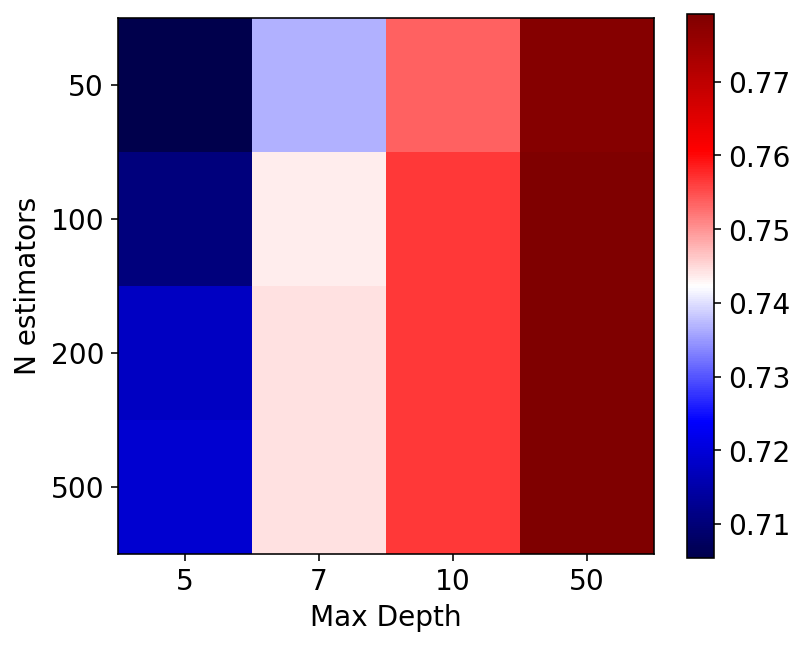

In [148]:
fig, ax = plt.subplots(figsize=(6, 5))
mapp = ax.imshow(results_xgb_train, cmap=plt.cm.seismic)
ax.set(ylabel='N estimators', xlabel='Max Depth',
       xticks=np.arange(0.0, 4.0, 1), yticks=np.arange(0.0, 4.0, 1),
       xticklabels=depths, yticklabels=n_ests)
fig.colorbar(mapp)

In [149]:
model = XGBRegressor(n_estimators=200, max_depth=10)
model.fit(Train, Train_target)
predictions = model.predict(test_features)

[11:49:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [150]:
submit('sub4', test_predictions)